In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def catboost_metric(model_cb, X_test, y_test ):
    y_pred_cb = model_cb.predict(X_test)
    y_pred_cb_proba = model_cb.predict_proba(X_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_pred_cb_proba)
    accuracy = accuracy_score(y_test, y_pred_cb)
    precision = precision_score(y_test, y_pred_cb)
    recall = recall_score(y_test, y_pred_cb)
    f1 = f1_score(y_test, y_pred_cb)

    metrics_cb = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc
        }
    return metrics_cb, y_pred_cb, y_pred_cb_proba

def lightgbm_metric( model, X_test, y_test):

    y_pred_lgb = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_lgb)   
    best_threshold = thresholds[(tpr - fpr).argmax()]
    print(best_threshold)

    roc_auc = roc_auc_score(y_test, y_pred_lgb)
    print(f'ROC AUC: {roc_auc:.4f}')
    y_pred = (y_pred_lgb >= best_threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    metrics = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc
        }
    return metrics, y_pred, y_pred_lgb

def plot_confusion_matrix(y_test, y_pred, title='Model'):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                cbar=False)
    plt.title(f'Confusion Matrix - {title}', fontsize=16, fontweight='bold')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()
    return plt


# Загрузка данных

In [3]:
train = pd.read_csv('train.csv')
train.create_time = pd.to_datetime(train.create_time)
train.model_create_time = pd.to_datetime(train.model_create_time)

test = pd.read_csv('test.csv')
test.create_time = pd.to_datetime(test.create_time)
test.model_create_time = pd.to_datetime(test.model_create_time)

web = pd.read_csv('t1_webstat.csv')
web.sort_values('date_time', inplace=True)
web.date_time = pd.to_datetime(web.date_time)

In [5]:
display(web, train)

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
2268917,109996122,1975-10-17 13:42:56.953,2,1,11.0,722.0,NaN,NaN,NaN,NaN
2268918,109996122,1975-10-17 13:43:07.510,2,2,22.0,7196.0,NaN,NaN,NaN,NaN
2268919,109996122,1975-10-17 13:43:29.860,2,3,25.0,779.0,NaN,NaN,NaN,NaN
2269206,109996122,1975-10-17 13:43:54.757,2,4,9.0,7196.0,NaN,NaN,NaN,NaN
2267445,109996122,1975-10-17 13:44:03.803,2,5,11.0,723.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2267023,134622417,1976-02-16 22:55:29.327,3,120,26.0,NaN,NaN,NaN,NaN,NaN
2267024,134622417,1976-02-16 22:55:55.497,1,121,17.0,4271.0,31165696.0,NaN,NaN,NaN
2078414,134622417,1976-02-16 22:56:12.727,2,122,159.0,4271.0,NaN,NaN,NaN,NaN
2000326,134622417,1976-02-16 22:58:51.717,7,123,51.0,NaN,NaN,NaN,NaN,NaN


,order_id,create_time,good_id,price,utm_medium,utm_source,sessionkey_id,category_id,parent_id,root_id,model_id,is_moderated,rating_value,rating_count,description_length,goods_qty,pics_qty,model_create_time,is_callcenter
0,1269921,1975-12-26 09:30:08,9896348,753,5,8.0,123777004,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20,1
1,1270034,1975-12-26 10:28:57,9896348,753,1,2.0,123781654,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20,0
2,1268272,1975-12-25 11:24:28,9896348,753,2,3.0,123591002,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20,1
3,1270544,1975-12-26 14:16:06,9896348,753,1,1.0,123832302,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20,1
4,1270970,1975-12-26 18:21:47,9896348,753,3,56.0,123881603,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104590,1250981,1975-12-16 12:11:32,68657110,1497,4,1.0,121795335,2873,1229,1183,35231362,1,4.0,3.0,1183,12,1,1976-01-23 00:08:20,1
104591,1173775,1975-11-08 11:29:50,60391507,1354,1,2.0,114277105,2873,1229,1183,35231362,1,4.0,3.0,1183,12,1,1976-01-23 00:08:20,1
104592,1180920,1975-11-12 09:14:35,66971400,1452,2,NaN,114972131,2873,1229,1183,35231362,1,4.0,3.0,1183,12,1,1976-01-23 00:08:20,0
104593,1177882,1975-11-10 17:28:07,60391498,1433,4,2.0,114672813,2873,1229,1183,35231362,1,4.0,3.0,1183,12,1,1976-01-23 00:08:20,1


In [17]:
web['date_time'].info()

<class 'pandas.core.series.Series'>
Index: 3334243 entries, 2268917 to 2059781
Series name: date_time
Non-Null Count    Dtype         
--------------    -----         
3334243 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 50.9 MB


In [32]:
session_agg = web.groupby('sessionkey_id', sort=False).agg(
    product_sale_count=('product_in_sale', 'sum'),
    total_sec_dt=('date_time', lambda x: (x.iloc[-1] - x.iloc[0]).total_seconds()),
    total_sec_dur=('pageview_duration_sec', 'sum'),
    unique_pages_count=('pageview_number', 'nunique'),
    mean_sec_dur=('pageview_duration_sec', 'mean'),
    max_sec_dur=('pageview_duration_sec', 'max'),
    total_receipt=('price', 'sum'),
    weekday_first_visit=('date_time', lambda x: str(x.iloc[0].weekday())),
    day_period_type=('date_time', lambda x: "0" if 5 <= x.iloc[0].hour < 12 else
                                            "1" if 12 <= x.iloc[0].hour < 18 else
                                            "2" if 18 <= x.iloc[0].hour < 23 else "3")
)

session_agg['sec_diff'] = session_agg['total_sec_dt'] - session_agg['total_sec_dur']

session_agg

,product_sale_count,total_sec_dt,total_sec_dur,unique_pages_count,mean_sec_dur,max_sec_dur,total_receipt,weekday_first_visit,day_period_type,sec_diff
sessionkey_id,,,,,,,,,,
109996122,0.0,89.680,90.0,7,15.000000,25.0,0.0,4,1,-0.320
110019268,1.0,165.560,165.0,3,82.500000,122.0,2986.0,4,1,0.560
110020180,1.0,0.000,0.0,1,NaN,NaN,4490.0,4,1,0.000
110040418,4.0,591.490,545.0,11,54.500000,281.0,2312.0,4,1,46.490
110044482,1.0,0.000,0.0,1,NaN,NaN,4490.0,4,1,0.000
...,...,...,...,...,...,...,...,...,...,...
134626779,0.0,0.000,22.0,1,22.000000,22.0,0.0,0,2,-22.000
134627402,1.0,298.784,244.0,7,40.666667,109.0,411.0,0,2,54.784
134628420,0.0,273.624,93.0,5,23.250000,45.0,0.0,0,2,180.624


In [61]:
X_tr = train.merge(session_agg, how='left', on='sessionkey_id', sort=False)
X_tr.sort_values('create_time', inplace=True)

cat_features= ['day_period_type', 'weekday_first_visit']


X_tr[cat_features] = X_tr[cat_features].fillna("missing")
X_tr = X_tr.fillna(0)

# X = X_tr.drop(columns=['is_callcenter'])
# y = X_tr['is_callcenter']

# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, 
#                                                       random_state=42, shuffle=False)

# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5,
#                                                   random_state=42, shuffle=False)

train_df, temp = train_test_split(X_tr, test_size=0.3, 
                                    random_state=42, shuffle=False)

val_df, test_df = train_test_split(temp, test_size=0.5,
                                                  random_state=42, shuffle=False)

In [62]:
X_tr[cat_features].info()

<class 'pandas.core.frame.DataFrame'>
Index: 104595 entries, 87721 to 84902
Data columns (total 2 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   day_period_type      104595 non-null  object
 1   weekday_first_visit  104595 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


In [15]:
train_df['is_callcenter'].value_counts()

is_callcenter
0    46816
1    26400
Name: count, dtype: int64

In [21]:
X_tr['day_period_type'].value_counts()

day_period_type
1.0    55642
0.0    28864
2.0    17237
3.0     2228
Name: count, dtype: int64

<Axes: xlabel='is_callcenter', ylabel='sec_diff'>

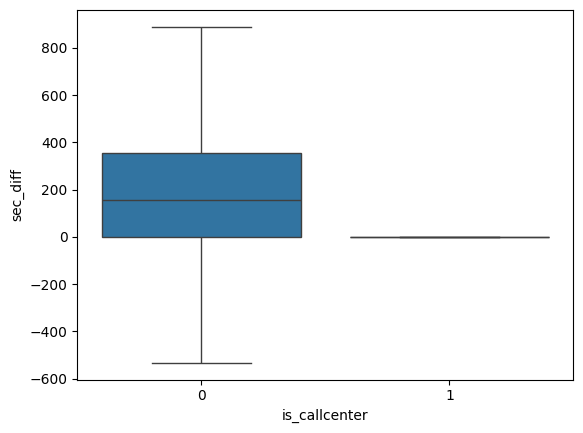

In [22]:
sns.boxplot(X_tr, y='sec_diff', x='is_callcenter', showfliers=False) # 0_0


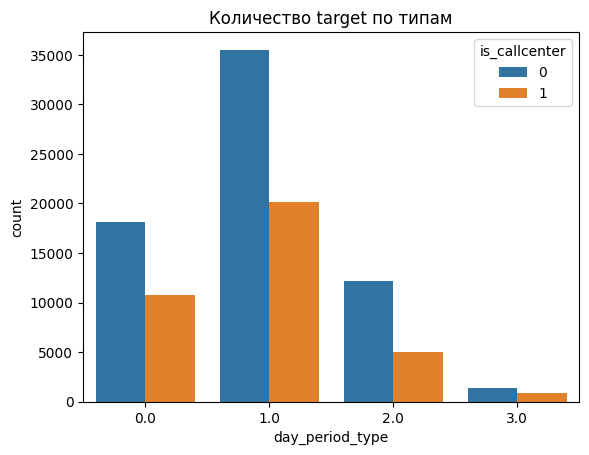

In [23]:

sns.countplot(x='day_period_type', hue='is_callcenter', data=X_tr)
plt.title('Количество target по типам')
plt.show()

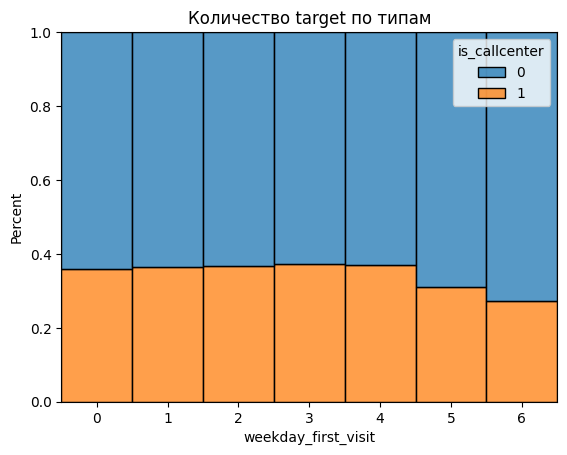

In [35]:

sns.histplot(x='weekday_first_visit', hue='is_callcenter', data=X_tr, stat='percent', discrete=True, multiple='fill')
plt.title('Количество target по типам')
plt.show()

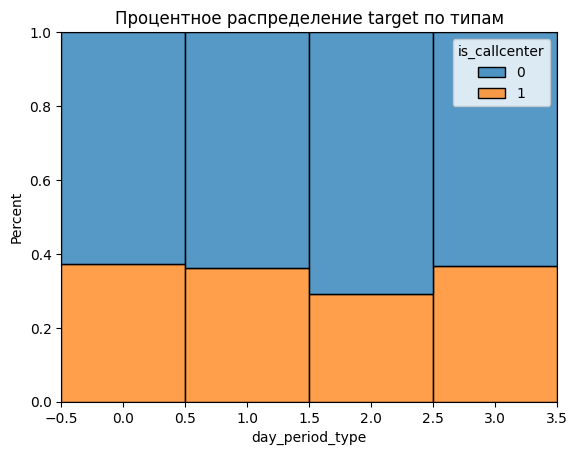

In [37]:
sns.histplot(x='day_period_type', hue='is_callcenter', data=X_tr, stat='percent', discrete=True, multiple='fill')
plt.title('Процентное распределение target по типам')
plt.show()

In [27]:
from catboost import CatBoostClassifier, Pool


params = {"score_function": 'L2',
          "depth": 5,
          "eta": 0.15,
          "eval_metric": 'AUC',
          "iterations": 570,
          "verbose": 50}

def catboost_train_model(train, valid, test, features, cat_features, params):

    train_pool_baseline = Pool(train[features], train['is_callcenter'], cat_features=cat_features)
    valid_pool_baseline = Pool(valid[features], valid['is_callcenter'], cat_features=cat_features)

    model_cb= CatBoostClassifier(**params)

    model_cb.fit(train_pool_baseline, eval_set=valid_pool_baseline, plot=True)
    metrics_cb_baseline, y_pred_cb, y_pred_cb_proba = catboost_metric(model_cb, test[features], test['is_callcenter'])
    print(metrics_cb_baseline)
    plot_confusion_matrix(test['is_callcenter'], y_pred_cb, title='CatBoost')
    return model_cb

In [42]:
train_df[['day_period_type', 'weekday_first_visit']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 73216 entries, 87721 to 70481
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   day_period_type      73216 non-null  object
 1   weekday_first_visit  73216 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8727231	best: 0.8727231 (0)	total: 20.8ms	remaining: 2.06s
50:	test: 0.8927591	best: 0.8927943 (45)	total: 1.12s	remaining: 1.08s
99:	test: 0.8932849	best: 0.8932879 (97)	total: 2.19s	remaining: 0us

bestTest = 0.8932878655
bestIteration = 97

Shrink model to first 98 iterations.
{'Accuracy': 0.8270235818992989, 'Precision': 0.6917355371900826, 'Recall': 0.8313468414779499, 'F1-Score': 0.7551425478166727, 'ROC-AUC': 0.8919513785239351}


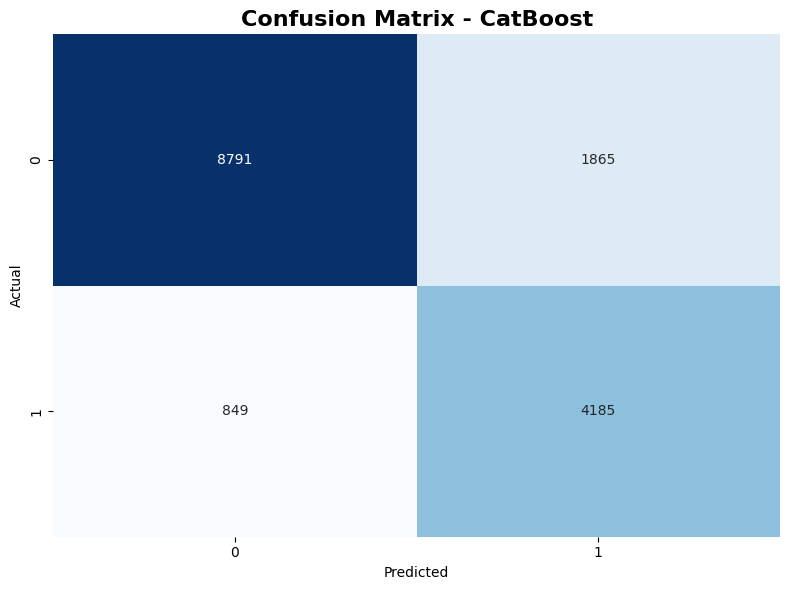

In [64]:
params = {"score_function": 'L2',
          "depth": 5,
          "eta": 0.15,
          "eval_metric": 'AUC',
          "iterations": 100,
          "verbose": 50}

cat_features= ['day_period_type', 'weekday_first_visit']

features = session_agg.columns
model_cd = catboost_train_model(train_df, val_df, test_df, features, cat_features, params)


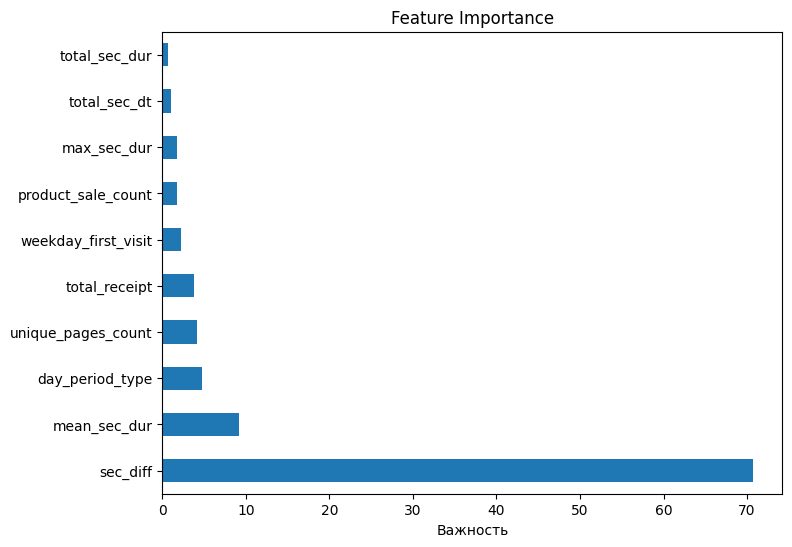

In [65]:
importances = pd.Series(model_cd.feature_importances_, index=features)
importances.nlargest(10).plot(kind='barh', figsize=(8, 6))
plt.title('Feature Importance')
plt.xlabel('Важность')
plt.show()

In [66]:
train_df[features]

,product_sale_count,total_sec_dt,total_sec_dur,unique_pages_count,mean_sec_dur,max_sec_dur,total_receipt,weekday_first_visit,day_period_type,sec_diff
87721,1.0,25.037,37.0,2.0,18.500000,25.0,584.0,5,0,-11.963
13972,13.0,4388.603,3720.0,30.0,128.275862,789.0,11280.0,5,0,668.603
90161,1.0,149.837,286.0,3.0,95.333333,137.0,510.0,5,0,-136.163
69290,13.0,4388.603,3720.0,30.0,128.275862,789.0,11280.0,5,0,668.603
4188,4.0,1638.040,1638.0,9.0,204.750000,944.0,5725.0,4,0,0.040
...,...,...,...,...,...,...,...,...,...,...
1986,5.0,989.797,805.0,11.0,80.500000,324.0,2726.0,0,1,184.797
25445,1.0,17.404,31.0,2.0,15.500000,18.0,25.0,0,1,-13.596
82013,1.0,75.287,75.0,2.0,75.000000,75.0,4726.0,6,3,0.287
62325,13.0,2242.270,2242.0,26.0,89.680000,630.0,18872.0,6,2,0.270
